# NBA Race to Contend : 40 before 20

*Excerpt from http://www.espn.com/nba/powerrankings?year=2008&week=18*

> The latest pearl of Zen wisdom from Phil Jackson: "40 before 20." Translation: You must win 40 games before you lose 20 to be seen as an elite team

## 1: Gathering Information and prototyping

First we should gather all the information about the teams for easier reference, we can take advange of the ``nba_api`` library and the static information it will provide. Let's look at what we can get

In [1]:
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
# What does this data look like?
nba_teams[2]

{'id': 1610612739,
 'full_name': 'Cleveland Cavaliers',
 'abbreviation': 'CLE',
 'nickname': 'Cavaliers',
 'city': 'Cleveland',
 'state': 'Ohio',
 'year_founded': 1970}

With this we can query the statistical endpoints from the nba website and the ``nba_api`` library.

We're interested in the magical win record score so we need to trace how a team progresses through the season. More importantly, **we don't want to just look at the end of the season to see a win record**, we're more interested in seeing if a team hit's 40 wins before 40 losses.

Let's extract the game record for a team.

In [2]:
from nba_api.stats.endpoints import teamgamelog

In [3]:
gsw = [team for team in nba_teams if team['abbreviation'] == 'GSW'][0]
gsw

{'id': 1610612744,
 'full_name': 'Golden State Warriors',
 'abbreviation': 'GSW',
 'nickname': 'Warriors',
 'city': 'Golden State',
 'state': 'California',
 'year_founded': 1946}

In [4]:
gameLog = teamgamelog.TeamGameLog(gsw['id']).get_dict()

The gameLog variable has quite a bit of information in it so let's inspect it and see what is accessible.

In [5]:
singleGame = gameLog['resultSets'][0]['rowSet'][0]
singleGame

[1610612744,
 '0021801062',
 'MAR 19, 2019',
 'GSW @ MIN',
 'W',
 48,
 22,
 0.686,
 240,
 44,
 91,
 0.484,
 19,
 42,
 0.452,
 10,
 14,
 0.714,
 8,
 38,
 46,
 39,
 6,
 7,
 13,
 25,
 117]

Well those are a bunch of weird values, thankfully they package the headers for us so let's combine the data for us to get a better sense of what the information is.

In [6]:
matchedValues = dict(zip(gameLog['resultSets'][0]['headers'],singleGame))
matchedValues

{'Team_ID': 1610612744,
 'Game_ID': '0021801062',
 'GAME_DATE': 'MAR 19, 2019',
 'MATCHUP': 'GSW @ MIN',
 'WL': 'W',
 'W': 48,
 'L': 22,
 'W_PCT': 0.686,
 'MIN': 240,
 'FGM': 44,
 'FGA': 91,
 'FG_PCT': 0.484,
 'FG3M': 19,
 'FG3A': 42,
 'FG3_PCT': 0.452,
 'FTM': 10,
 'FTA': 14,
 'FT_PCT': 0.714,
 'OREB': 8,
 'DREB': 38,
 'REB': 46,
 'AST': 39,
 'STL': 6,
 'BLK': 7,
 'TOV': 13,
 'PF': 25,
 'PTS': 117}

NBA actually provides us with quite a bit of information. But we're primarily interested in the `WL` value. Unfortunetly we're not given a dictionary structure so we can't refer to it in a "nice" way, we'll just have to remember that the 4th record.

So `gameLog['resultSets'][0]['rowSet'][i][4]` will give us the `WL` record for game `i`.

Let's gather all the games available and see what we get.

In [7]:
for game in gameLog['resultSets'][0]['rowSet']:
    print(game[4])

W
L
W
W
L
W
L
W
L
L
W
L
W
L
W
W
W
W
W
L
W
W
W
W
W
W
W
W
W
W
W
L
W
W
L
L
W
W
L
W
W
L
W
W
W
W
L
L
W
W
W
L
L
L
L
W
L
W
L
W
W
W
W
W
W
W
W
L
W
W


This structure of code is quite common so we can take advantage of python ***List Comprehensions***. This will automatically take our loop and store the values in the variable.

In [8]:
winLossRecord = [game[4] for game in gameLog['resultSets'][0]['rowSet']]

In [9]:
# Let's look at 10 records
winLossRecord[:10]

['W', 'L', 'W', 'W', 'L', 'W', 'L', 'W', 'L', 'L']

An issue with this format is that games are either Win or Loss, but we're given a character as that representation. A `True` or `False` condition of whether or not the team had won makes more sense. Let's convert those characters to a more friendly `boolean` type.

All we need to do is ask if the character is a `'W'` or not.

In [10]:
winLossRecord = [game[4] == 'W' for game in gameLog['resultSets'][0]['rowSet']]
winLossRecord.reverse() #The api returns the most recent game first. We want to start with the oldest game (game 1)
winLossRecord[:10]

[True, True, False, True, True, True, True, True, True, True]

This will let us do more interesting computations.

Going back to what we're interested in, we'd like to compute the win record as a rolling value. This will be good for our visualizations in a bit, but to give an example of what transformation we want to see consider the following:

`[False, True, False, True, False, False, True, False, True, False]` to become

`[0, 1, 1, 2, 2, 2, 3, 3, 4, 4]`

This transformation is a bit more nuanced but we can take advantage of some really cool ["code-golf"](https://codegolf.stackexchange.com/) features within python, but be warned that [Here be Dragons](https://www.wikiwand.com/en/Here_be_dragons) but we will work it out.

In [11]:
rollingCount = [winLossRecord[:x+1].count(True) for x in range(len(winLossRecord))]
rollingCount[:10]

[1, 2, 2, 3, 4, 5, 6, 7, 8, 9]

Quite the one liner. Now this isn't the most efficient code but it is the most succint. Let's look into it a little bit more to figure out what is going on.

`range(len(winLossRecord))` gives us an index for every value in the `winLossRecord` list and stores that value in `x`.

Once we have that, we can go back into `winLossRecord` and slice, or give us a subsection of the list, from the first value to the `x+1` value. From there, we ask to count how many `True` values exist.

This is what is considered a "cute" solution, it's not the most efficient, but it's succint. [Some soon to be implemented features in python can help make the solution efficient and "cute'](https://www.python.org/dev/peps/pep-0572/).

Now we can see a win record as we progress through the season. Let's see how that looks plotted.

In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib notebook

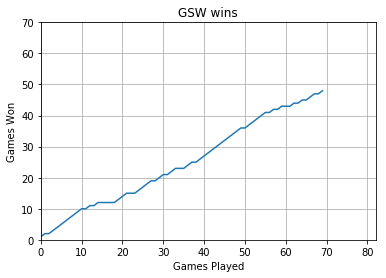

In [13]:
gameRange = np.arange(len(rollingCount))
plt.plot(gameRange, rollingCount)

# Plot labels and formatting
plt.title(gsw['abbreviation']+" wins")
plt.xlabel('Games Played')
plt.ylabel('Games Won')
plt.xlim([0,82])
plt.ylim([0,len(rollingCount)])
plt.grid(True)

Now we've got a pretty good prototype of a running win rate graph. With grids enabled we can get a good sense for progress, but let's make it more obvious.

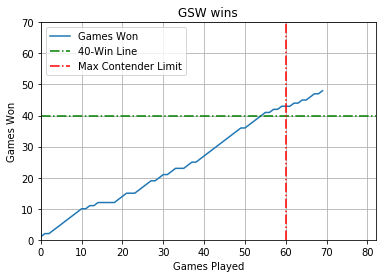

In [14]:
gameRange = np.arange(len(rollingCount))
plt.plot(gameRange, rollingCount, label="Games Won")

plt.axhline(y=40, color='g', label="40-Win Line", linestyle="-.")
plt.axvline(x=60, color='r', label="Max Contender Limit", linestyle="-.")

# Plot labels and formatting
plt.title(gsw['abbreviation']+" wins")
plt.xlabel('Games Played')
plt.ylabel('Games Won')
plt.xlim([0,82])
plt.ylim([0,len(rollingCount)])
plt.legend(loc="upper left")
plt.grid(True)

That looks pretty good. Let's generalize this for any given team.

## 2: Generalize

In [15]:
def contenderGraph(team_abbrev):
    # First find the team given the proper abbreviation
    team_data = [team for team in nba_teams if team['abbreviation'] == team_abbrev][0]
    
    # Get the gameLog and format it
    gameLog = teamgamelog.TeamGameLog(team_data['id']).get_dict()
    winLossRecord = [game[4] == 'W' for game in gameLog['resultSets'][0]['rowSet']]
    winLossRecord.reverse()
    
    # Calculate rolling count
    rollingCount = [winLossRecord[:x+1].count(True) for x in range(len(winLossRecord))]
    
    # Plot results
    gameRange = np.arange(len(rollingCount))
    plt.plot(gameRange, rollingCount, label="Games Won")

    plt.axhline(y=40, color='g', label="40-Win Line", linestyle="-.")
    plt.axvline(x=60, color='r', label="Max Contender Limit", linestyle="-.")

    # Plot labels and formatting
    plt.title(team_data['abbreviation']+" contender graph")
    plt.xlabel('Games Played')
    plt.ylabel('Games Won')
    plt.xlim([0,82])
    plt.ylim([0,len(rollingCount)])
    plt.legend(loc="upper left")
    plt.grid(True)

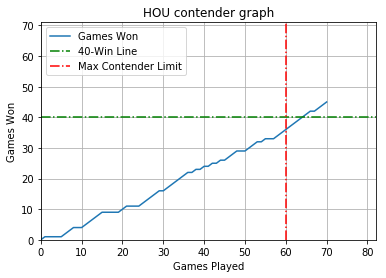

In [16]:
contenderGraph('HOU')

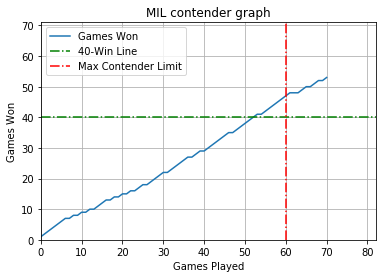

In [17]:
contenderGraph('MIL')

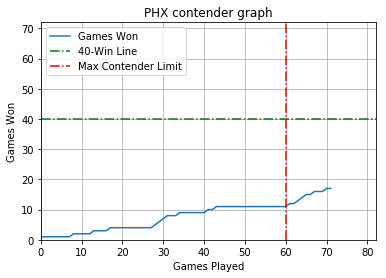

In [18]:
contenderGraph('PHX')

That looks pretty good, but it's annoying to look at the same information over and over, let's make another function that allows us to compare multiple teams

In [19]:
def overlayContenderGraph(multiple_team_abbrev):
    assert isinstance(multiple_team_abbrev,list), 'Required a list of teams'
    
    # First find the team given the proper abbreviation
    
    team_data = [team for team in nba_teams if team['abbreviation'] in multiple_team_abbrev]
    
    # Get the gameLog and format it
    for team in team_data:
        gameLog = teamgamelog.TeamGameLog(team['id']).get_dict()
        winLossRecord = [game[4] == 'W' for game in gameLog['resultSets'][0]['rowSet']]
        winLossRecord.reverse()
    
    # Calculate rolling count
        rollingCount = [winLossRecord[:x+1].count(True) for x in range(len(winLossRecord))]
    
    # Plot results
        gameRange = np.arange(len(rollingCount))
        plt.plot(gameRange, rollingCount, label=team['abbreviation'])

    plt.axhline(y=40, color='g', label="40-Win Line", linestyle="-.")
    plt.axvline(x=60, color='r', label="Max Contender Limit", linestyle="-.")

    # Plot labels and formatting
    plt.title(' '.join(multiple_team_abbrev)+" contender graph")
    plt.xlabel('Games Played')
    plt.ylabel('Games Won')
    plt.xlim([0,82])
    plt.ylim([0,len(rollingCount)])
    plt.legend(loc="upper left")
    plt.grid(True)

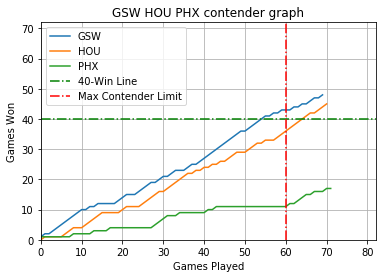

In [20]:
overlayContenderGraph(['GSW','HOU','PHX'])

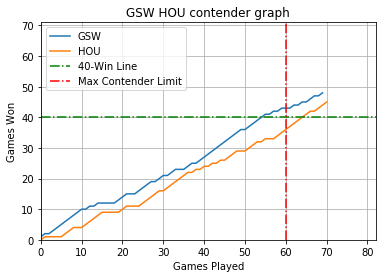

In [21]:
overlayContenderGraph(['GSW','HOU'])

# 3: Probabilities

This is all nice and good. Let's see how many of these teams exist and more specifically, come up with a way to define Phil's formula.

By 60 games you should have at least 40 wins. So we can determine a probability factor as the following point in the season, *g*, we should see the following formula. 

*Note: This calculation only matters before you hit the 60 game mark and also assumes that each game is a perfect coin flip (50%), we do not take into account the probability of the matchup*

$$F(i=\text{winsNeeded}, g=\text{gamesLeft}) = \sum_{i}^{g} {g \choose i} \left(\frac{1}{2}\right)^i \left(1 - \frac{1}{2}\right)^{g-i} $$

In [22]:
# Helper function for combinatorical function nCr
import operator as op
from functools import reduce

def nCr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

In [23]:
# Helper function to return Win Loss Record given a teamgamelog dictionary
def winLoss(team_log):
    gameList = team_log['resultSets'][0]['rowSet']
    if gameList[0][5] == None:
        # If when we query there happens to be a game going on, we have to look at the prev game.
        return (gameList[1][5],gameList[1][6])
    return (gameList[0][5],gameList[0][6])

In [24]:
def winLoss_atSpecificTime(team_log,specificTime=59):
    gameList = team_log['resultSets'][0]['rowSet'].copy()
    gameList.reverse()
    return (gameList[specificTime][5],gameList[specificTime][6])

In [30]:
winLoss(gameLog)

(48, 22)

In [32]:
winLoss_atSpecificTime(gameLog,8)

(8, 1)

In [33]:
def runningProbability(winsNeeded, gamesLeft, eventProbability = 0.5):
    runningTotal = 0
    for i in range(winsNeeded, gamesLeft+1):
        runningTotal += nCr(gamesLeft,i) * (eventProbability**i) * ((1-eventProbability)**(gamesLeft-i))
    return runningTotal

In [34]:
def probability(team_dict):
    teamWins, teamLoss = winLoss(team_dict)
    gamesPlayed = teamWins + teamLoss
    if teamLoss >= 20 and gamesPlayed <= 60:
        return 0
    elif teamWins >= 40:
        return 1
    else:
        return runningProbability(40-teamWins, 60-gamesPlayed)

In [35]:
def probability_atSpecificTime(team_dict,specificTime=59):
    teamWins, teamLoss = winLoss_atSpecificTime(team_dict,specificTime)
    gamesPlayed = teamWins + teamLoss
    if teamLoss >= 20 and gamesPlayed <= 60:
        return 0
    elif teamWins >= 40:
        return 1
    else:
        return runningProbability(40-teamWins, 60-gamesPlayed)

In [36]:
gsw_teamDict = teamgamelog.TeamGameLog(gsw['id']).get_dict()

In [37]:
winLoss_atSpecificTime(gsw_teamDict,50)

(36, 15)

In [38]:
print("{:.2%}".format(probability_atSpecificTime(gsw_teamDict,50)))

74.61%


Ok. That's a lot of code that we just wrote up but let's see how it plots out

In [39]:
probOverTime = [probability_atSpecificTime(gsw_teamDict,i) for i in range(60)]

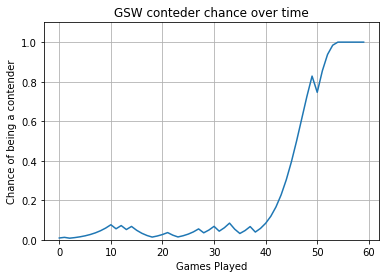

In [41]:
gameRange = np.arange(len(probOverTime))
plt.plot(gameRange, probOverTime)

# Plot labels and formatting

plt.title(gsw['abbreviation']+" conteder chance over time")
plt.xlabel('Games Played')
plt.ylabel('Chance of being a contender')
plt.ylim([0,1.1])
plt.grid(True)


Cool! Let's generalize this to a function so we can look at a couple teams easily.

In [116]:
def contenderChanceGraph(multiple_teamDict,maxRange=60):
    assert isinstance(multiple_teamDict,list), 'Required a list of teams'
    
    teamNames = []
    for teamDict in multiple_teamDict:
        teamConstants = [team for team in nba_teams if team['id'] == teamDict['parameters']['TeamID']][0]
        probOverTime = [probability_atSpecificTime(teamDict,i) for i in range(maxRange)]
        plt.plot(np.arange(maxRange), probOverTime, label=teamConstants['abbreviation'])
        teamNames.append(teamConstants['abbreviation'])
    
    # Plot labels and formatting
    
    
    plt.title(' '.join(teamNames)+" conteder chance over time")
    plt.xlabel('Games Played')
    plt.ylabel('Chance of being a contender')
    plt.ylim([-0.1,1.1])
    plt.legend(loc="upper left")
    plt.grid(True)

In [117]:
MIL = [team for team in nba_teams if team['abbreviation'] == 'MIL'][0]
mil_teamDict = teamgamelog.TeamGameLog(MIL['id']).get_dict()

DEN = [team for team in nba_teams if team['abbreviation'] == 'DEN'][0]
den_teamDict = teamgamelog.TeamGameLog(DEN['id']).get_dict()

PHX = [team for team in nba_teams if team['abbreviation'] == 'PHX'][0]
phx_teamDict = teamgamelog.TeamGameLog(PHX['id']).get_dict()

TOR = [team for team in nba_teams if team['abbreviation'] == 'TOR'][0]
tor_teamDict = teamgamelog.TeamGameLog(TOR['id']).get_dict()

HOU = [team for team in nba_teams if team['abbreviation'] == 'HOU'][0]
hou_teamDict = teamgamelog.TeamGameLog(HOU['id']).get_dict()

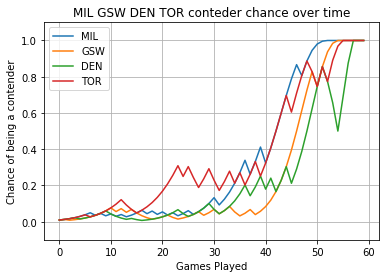

In [118]:
contenderChanceGraph([mil_teamDict, gsw_teamDict, den_teamDict, tor_teamDict])

In [119]:
import matplotlib.ticker as mtick

def overlayedGraphs(team_dict,maxRange=60):
    # Probability Data
    probOverTime = [probability_atSpecificTime(team_dict,i) for i in range(maxRange)]
    # Wins Over Time Data
    winLossRecord = [game[4] == 'W' for game in team_dict['resultSets'][0]['rowSet']].copy()
    winLossRecord.reverse()
    rollingCount = [winLossRecord[:x+1].count(True) for x in range(maxRange)]
    
    
    
    #Plot probability
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Games Played')
    ax1.set_ylabel('% Chance',color=color)
    ax1.plot(np.arange(maxRange), probOverTime, label="Contender Chance", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(which='major', axis='x', linestyle='--')
    
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

    
    #Plot wins
    ax2 = ax1.twinx()
    
    
    color = 'tab:blue'
    ax2.set_ylabel('Games Won',color=color)
    ax2.plot(np.arange(maxRange), rollingCount, label="Wins", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(which='major',axis='y',linestyle='--')
    
    #Setup nice things            
    teamConstants = [team for team in nba_teams if team['id'] == team_dict['parameters']['TeamID']][0]
    plt.title(teamConstants['abbreviation']+" conteder chance over time")
    
    
    fig.tight_layout()
    
    fig.legend(loc="upper left",  bbox_to_anchor=(0.13,.9))

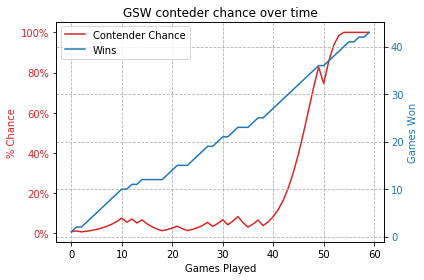

In [120]:
overlayedGraphs(gsw_teamDict)

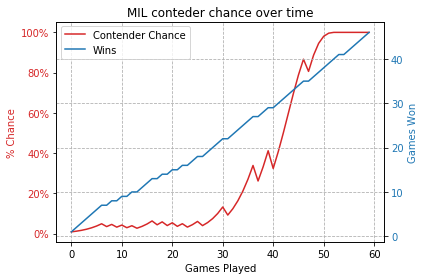

In [121]:
overlayedGraphs(mil_teamDict)

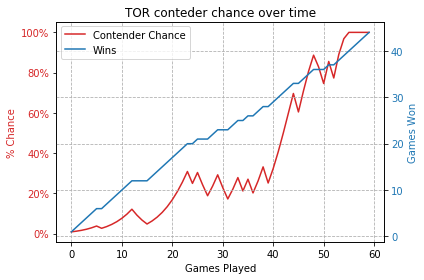

In [122]:
overlayedGraphs(tor_teamDict)

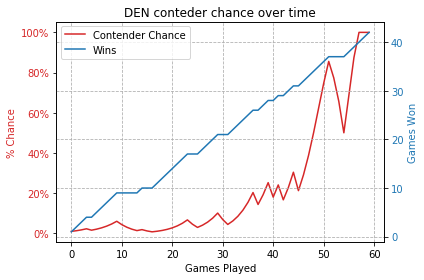

In [123]:
overlayedGraphs(den_teamDict)

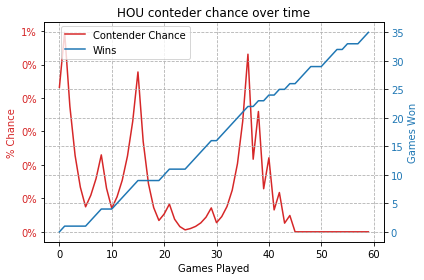

In [124]:
overlayedGraphs(hou_teamDict)

Now this is a fun one. In the current state of the function it does not keep the percentage chance at a constant 0 to 100, so you can see how some teams can have some interesting results.